## Fastext своими руками

Fastext использует те же самые алгоритмы, что и word2vec. Единственное (но очень значимое) отличие в том, что в fastext используются не только слова, но и символьные нграммы. Это частично помогает решить проблему с несловарными словами. Если в словаре word2vec модели нет нужного слова, то никакого вектора для него создать не получится. В fastext же, если слова нет в словаре целиком, то можно проверить по словарю символьные нграммы этого слова и составить итоговый вектор из них. Большинство несловарных слов сильно пересекаются со словарными (основами, аффиксами) и за счет этого найденный вектор получается достаточно хороший.
Реализовать простую версию fastext немного сложнее, поэтому я вынес его в отдельный ноутбук.

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import random
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_distances

from IPython.display import Image
from IPython.core.display import HTML
%matplotlib inline

In [2]:
import os
os.environ["KERAS_BACKEND"] = "torch"
# os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

import torch
# torch.set_default_device('cpu')

import keras
print(keras.__version__)

3.5.0


Возьмем тот же небольшой кусок википедии

In [3]:
# в нашем корпусе 20к текстов
wiki = open('wiki_data.txt').read().split('\n')

In [4]:
wiki[0]

'######Новостройка (Нижегородская область)############Новостро́йка — сельский посёлок в Дивеевском районе Нижегородской области. Входит в состав Сатисского сельсовета.############Посёлок расположен в 12,5 км к югу от села Дивеева и 1 км к западу от города Сарова, на правом берегу реки Вичкинза (правый приток реки Сатис). Окружён смешанными лесами. Соединён асфальтовой дорогой с посёлком Цыгановка (1,5 км) и грунтовыми просёлочными дорогами с посёлком Сатис (3,5 км). Название Новостройка является сугубо официальным, местное население использует исключительно альтернативное название — Хитрый. Употребляется языковой оборот «…на Хитром». Ранее используемые названия — Песчаный, Известковый.############Основан в 1920-х годах переселенцами из соседних сёл Аламасово и Нарышкино (расположенных соответственно в 8 и 14 км к западу в Вознесенском районе).############Традиционно в посёлке жили рабочие совхоза «Вперёд» (центр в посёлке Сатис). Возле посёлка расположен карьер где активно добывали дол

In [5]:
len(wiki)

20003

Базовая токенизация остается точно такой же

In [6]:
import re
from collections import Counter
def tokenize(text):
    tokens = re.sub('#+', ' ', text.lower()).split()
    tokens = [token.strip(punctuation) for token in tokens]
    tokens = [token for token in tokens if token]
    return tokens


Второй базовый элемент - это нграммер, чтобы разбивать токен на символьные нграммы
Обратите внимание что к токену добавляются <> чтобы учесть в нграммах, что они стоят в начале или в конце

In [7]:
def ngrammer(raw_string, n=2):
    ngrams = []
    raw_string = ''.join(['<', raw_string, '>'])
    for i in range(0,len(raw_string)-n+1):
        ngram = ''.join(raw_string[i:i+n])
        if ngram == '<' or ngram == '>': # сами по себе <> как токены не нужны
            continue
        ngrams.append(ngram)
    return ngrams

Следующая функция проходится по токенам и разбивает каждый токен на подсимвольные нграммы в заданном интервале

In [8]:
def split_tokens(tokens, min_ngram_size, max_ngram_size):
    tokens_with_subwords = []
    for token in tokens:
        subtokens = []
        for i in range(min_ngram_size, max_ngram_size+1):
            if len(token) > i:
                subtokens.extend(ngrammer(token, i))
        tokens_with_subwords.append(subtokens)
    return tokens_with_subwords


In [9]:
split_tokens(['подсимвольные', 'нграммы'], 3, 4)

[['<по',
  'под',
  'одс',
  'дси',
  'сим',
  'имв',
  'мво',
  'вол',
  'оль',
  'льн',
  'ьны',
  'ные',
  'ые>',
  '<под',
  'подс',
  'одси',
  'дсим',
  'симв',
  'имво',
  'мвол',
  'воль',
  'ольн',
  'льны',
  'ьные',
  'ные>'],
 ['<нг',
  'нгр',
  'гра',
  'рам',
  'амм',
  'ммы',
  'мы>',
  '<нгр',
  'нгра',
  'грам',
  'рамм',
  'аммы',
  'ммы>']]

Теперь нам нужно спаппить токены и подсимвольные нграммы в индексы и для этого нужно построить словарь. Это немного сложнее чем раньше потому что мы хотим иметь в словаре и полные слова и символьные нграммы, но нам нужно иметь отдельный список только полных слов, чтобы потом иметь возможность находить ближайшие слова.

Чтобы было удобнее со всеми переменными напишем класс для токенизации

In [10]:
class SubwordTokenizer:
    def __init__(self, ngram_range=(1,1), min_count=5):
        self.min_ngram_size, self.max_ngram_size = ngram_range
        self.min_count = min_count
        self.subword_vocab = None
        self.fullword_vocab = None
        self.fullword_vocab_tuple = None
        self.vocab = None
        self.id2word = None
        self.word2id = None

    def build_vocab(self, texts):
        # чтобы построить словарь нужно пройти по всему корпусу и собрать частоты всех уникальных слов и нграммов
        unfiltered_subword_vocab = Counter()
        unfiltered_fullword_vocab = Counter()
        for text in texts:
            tokens = tokenize(text)
            unfiltered_fullword_vocab.update(tokens)
            subwords_per_token = split_tokens(tokens, self.min_ngram_size, self.max_ngram_size)
            for subwords in subwords_per_token:
                # в одном слове могут быть одинаковые нграммы поэтому возьмем только уникальные
                unfiltered_subword_vocab.update(set(subwords))

        self.fullword_vocab = set()
        self.subword_vocab = set()

        # теперь отфильтруем по частоте
        for word, count in unfiltered_fullword_vocab.items():
            if count >= self.min_count:
                self.fullword_vocab.add(word)
        # для нграммов сделаем порог побольше чтобы не создавать слишком много нграммов
        # и учитывать только действительно частотные
        for word, count in unfiltered_subword_vocab.items():
            if count >= (self.min_count * 100):
                self.subword_vocab.add(word)

        # общий словарь
        self.fullword_vocab_tuple = tuple(self.fullword_vocab)
        self.vocab = self.fullword_vocab | self.subword_vocab
        self.id2word = {i:word for i,word in enumerate(self.vocab)}
        self.word2id = {word:i for i,word in self.id2word.items()}

    def subword_tokenize(self, text):
        if self.vocab is None:
            raise AttributeError('Vocabulary is not built!')
        # разбиваем на токены
        tokens = tokenize(text)
        # каждый токен разбиваем на символьные нграммы
        tokens_with_subwords = split_tokens(tokens, self.min_ngram_size, self.max_ngram_size)
        # оставляет только токены и нграммы которые есть в словаре
        only_vocab_tokens_with_subwords = []
        for full_token, sub_tokens in zip(tokens, tokens_with_subwords):
            filtered = []
            if full_token in self.vocab:
                # само слово и нграммы хранятся в одном списке
                # но слово будет всегда первым в списке
                filtered.append(full_token)
            filtered.extend([subtoken for subtoken in set(sub_tokens) if subtoken in self.vocab])
            only_vocab_tokens_with_subwords.append(filtered)

        return only_vocab_tokens_with_subwords

    def encode(self, subword_tokenized_text):
        # маппим токены и нграммы в их индексы в словаре
        encoded_text = []
        for token in subword_tokenized_text:
            if not token:
                continue
            encoded_text.append([self.word2id[token[0]]] + [self.word2id[t] for t in set(token[1:]) if t in self.word2id and t != token[0]])
        return encoded_text

    def __call__(self, text):
        return self.encode(self.subword_tokenize(text))


In [11]:
tokenizer = SubwordTokenizer(ngram_range=(2,4), min_count=10)

In [12]:
tokenizer.build_vocab(wiki)

In [13]:
tokenizer.subword_tokenize('Текст для тестирования токенизации')

[['текст',
  'тек',
  'екс',
  '<тек',
  '<те',
  'кс',
  'ек',
  'екст',
  'т>',
  'кст',
  'ст>',
  '<т',
  'текс',
  'ст',
  'те'],
 ['для', 'дл', 'ля', 'я>', '<д'],
 ['тестирования',
  'ти',
  'ва',
  'я>',
  'ест',
  'тир',
  'ир',
  'ова',
  'тиро',
  'ров',
  'сти',
  'тест',
  'ст',
  'ро',
  'рова',
  'иров',
  'вани',
  '<те',
  'те',
  'ани',
  'ни',
  'ести',
  'ия',
  'ния',
  'ия>',
  'ов',
  'ован',
  'ес',
  'иро',
  'тес',
  'ания',
  'ния>',
  '<т',
  'ван',
  'ан'],
 ['ок',
  'из',
  '<то',
  'зац',
  'ац',
  'ени',
  'аци',
  'ии>',
  'ци',
  'оке',
  'кен',
  'ции>',
  'ни',
  'ке',
  'и>',
  'изац',
  'заци',
  'ток',
  'то',
  'ции',
  'иза',
  'низ',
  'ен',
  'ии',
  'ации',
  'за',
  'токе',
  '<т',
  'низа']]

In [14]:
len(tokenizer.vocab)

54860

In [15]:
tokenizer('Текст для тестирования токенизации')

[[16116,
  46041,
  53670,
  51635,
  246,
  13924,
  53126,
  21979,
  524,
  50573,
  30712,
  41912,
  26550,
  44451,
  46859],
 [23279, 36211, 10628, 43000, 12403],
 [890,
  42503,
  19380,
  13519,
  24741,
  43000,
  50409,
  40688,
  28115,
  1437,
  5155,
  41613,
  4247,
  246,
  2176,
  53530,
  5884,
  18824,
  13924,
  29864,
  20042,
  6002,
  52609,
  44566,
  2320,
  52666,
  11455,
  6125,
  37469,
  43452,
  36236,
  43093,
  44451,
  30777,
  21979],
 [41839,
  35642,
  3539,
  33855,
  52476,
  23039,
  4236,
  2467,
  53571,
  28059,
  26005,
  17565,
  20042,
  47695,
  25736,
  23239,
  41671,
  38338,
  38802,
  6230,
  7894,
  51708,
  34871,
  46728,
  9233,
  44681,
  18057,
  44451,
  40681]]

Реализуем функцию которая будет генерировать батчи для обучения. Сделаем только скипграмм алгоритм. То есть нам нужны пары токен_1 - токен_2 встретившиеся в одном контексте, только для токена_1 мы еще будет учитывать его символьный нграммы, а токен_2 будет предсказывать только целиком без разбиение на поднграммы

In [16]:
def gen_batches_ft(sentences, tokenizer, window = 5, batch_size=1000, maxlen=20):

    left_context_length = (window/2).__ceil__()
    right_context_length = window // 2

    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            sent = tokenizer(sent)
            for i in range(len(sent)-1):
                word_with_subtokens = sent[i]
                context = sent[max(0, i-left_context_length):i] + sent[i+1:i+right_context_length]
                for context_word_with_subtokens in context:
                    # целевой токен всегда только целый
                    # мы берем первый токен из списка который вернул токенайзер
                    # там у нас будет лежать целое слово
                    only_full_word_context_token = context_word_with_subtokens[0]

                    X_target.append(word_with_subtokens)
                    X_context.append(only_full_word_context_token)
                    y.append(1)

                    X_target.append(word_with_subtokens)
                    X_context.append(tokenizer.word2id[random.choice(tokenizer.fullword_vocab_tuple)])
                    y.append(0)

                    if len(X_target) >= batch_size:
                        # тут нам понадобится паддинг так как количество сивольных нграммов будет зависеть от длины токенов
                        X_target = np.array(keras.preprocessing.sequence.pad_sequences(X_target, maxlen=maxlen))
                        X_context = np.array(X_context)
                        y = np.array(y)
                        yield ((X_target, X_context), y)
                        X_target = []
                        X_context = []
                        y = []

In [17]:
gen = gen_batches_ft(wiki, tokenizer, batch_size=5)

In [18]:
next(gen)

((array([[53525, 22579,   246, 53530, 18298, 26006, 42219, 24455,  6291,
          21227, 40554, 41251, 39142, 52666, 10218, 40897, 35271, 34313,
          50027, 25609],
         [53525, 22579,   246, 53530, 18298, 26006, 42219, 24455,  6291,
          21227, 40554, 41251, 39142, 52666, 10218, 40897, 35271, 34313,
          50027, 25609],
         [17831,  9373, 53642,  8996, 20042, 21861, 34511, 16234, 54410,
          47147, 54361, 39142, 11450, 36795, 19819,  3342, 19008, 34313,
          21772, 54046],
         [17831,  9373, 53642,  8996, 20042, 21861, 34511, 16234, 54410,
          47147, 54361, 39142, 11450, 36795, 19819,  3342, 19008, 34313,
          21772, 54046],
         [17831,  9373, 53642,  8996, 20042, 21861, 34511, 16234, 54410,
          47147, 54361, 39142, 11450, 36795, 19819,  3342, 19008, 34313,
          21772, 54046],
         [17831,  9373, 53642,  8996, 20042, 21861, 34511, 16234, 54410,
          47147, 54361, 39142, 11450, 36795, 19819,  3342, 19008, 34313,

Код для обучения очень простой. Мы просто сопостовляет каждому токену и нграмму эмбединг и усредняем все эмбединги внутри слова, чтобы получить итоговый. По нему мы пытаемся предсказать целевое слово.

In [19]:
inputs_target = keras.layers.Input(shape=(20,))
inputs_context = keras.layers.Input(shape=(1,))

embeddings_target = keras.layers.Embedding(input_dim=len(tokenizer.vocab), output_dim=300)(inputs_target, )
embeddings_context = keras.layers.Embedding(input_dim=len(tokenizer.vocab), output_dim=300)(inputs_context, )

target = keras.layers.Lambda(
    lambda x: tf.reduce_sum(x, axis=1), output_shape=(300,))(embeddings_target)
print(target)
context = keras.layers.Flatten()(embeddings_context)
print(context)

dot = keras.layers.Dot(1)([target, context])
outputs = keras.layers.Activation(activation='sigmoid')(dot)

model = keras.Model(inputs=[inputs_target, inputs_context],
                       outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

<KerasTensor shape=(None, 300), dtype=float32, sparse=False, name=keras_tensor_4>
<KerasTensor shape=(None, 300), dtype=float32, sparse=False, name=keras_tensor_5>


In [20]:
model.build([(None, 20), (None, 1)])

In [21]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 20)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 20, 300)        │     16,458,000 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 1, 300)         │     16,458,000 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 300)            │              0 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 300)            │              0 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dot (Dot)                 │ (None, 1)              │              0 │ lambda[0][0],          │
│                           │                        │                │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 1)              │              0 │ dot[0][0]              │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 32,916,000 (125.56 MB)

 Trainable params: 32,916,000 (125.56 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model.fit(gen_batches_ft(wiki[:19000],tokenizer, window=10, batch_size=100),
          validation_data=gen_batches_ft(wiki[19000:], tokenizer, window=10, batch_size=100),
          batch_size=2000,
          steps_per_epoch=10000,
          validation_steps=100,
          epochs=5)

Epoch 1/5
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 99s 10ms/step - accuracy: 0.7352 - loss: 0.5180 - val_accuracy: 0.7742 - val_loss: 0.4941
Epoch 2/5
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 92s 9ms/step - accuracy: 0.8153 - loss: 0.4178 - val_accuracy: 0.8033 - val_loss: 0.4525
Epoch 3/5
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 91s 9ms/step - accuracy: 0.8283 - loss: 0.3926 - val_accuracy: 0.7812 - val_loss: 0.4705
Epoch 4/5
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 91s 9ms/step - accuracy: 0.8232 - loss: 0.4027 - val_accuracy: 0.8046 - val_loss: 0.4414
Epoch 5/5
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 91s 9ms/step - accuracy: 0.8289 - loss: 0.3921 - val_accuracy: 0.8132 - val_loss: 0.4266


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


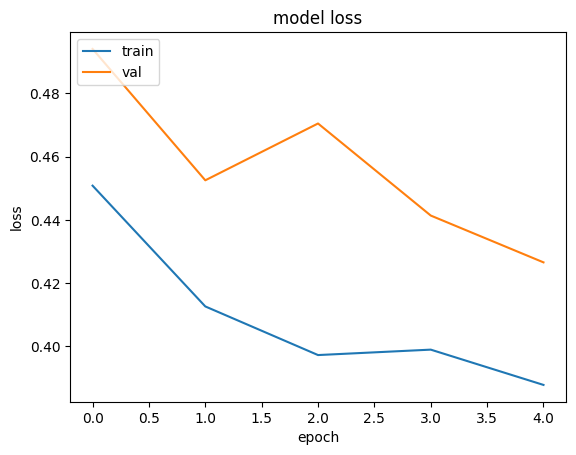

In [23]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Искать похожие немного сложнее так как нам нужно для всех полных слов еще и учесть информацию об их поднграммах.

In [24]:
embeddings = model.layers[2].get_weights()[0] # матрица со всеми эмбедингами

In [25]:
full_word_embeddings = np.zeros((len(tokenizer.fullword_vocab), 300)) # матрица с эмбедингами полных слов + нграммы
id2word = list(tokenizer.fullword_vocab)

for i, word in enumerate(tokenizer.fullword_vocab):
    subwords = tokenizer(word)[0]
    full_word_embeddings[i] = embeddings[[i for i in subwords]].mean(axis=0)

In [26]:
def most_similar_ft(word, embeddings, tokenizer):
    subwords = tokenizer(word)[0]
    word_embedding = embeddings[[i for i in subwords]].sum(axis=0)
    # idxs = [tokenizer.word2id[i] for i in tokenizer.fullword_vocab]
    similar = [id2word[i] for i in
               cosine_distances(word_embedding.reshape(1, -1), full_word_embeddings).argsort()[0][:20]]
    return similar

Из результатов поиска видно что fastext учитывает поднграмы и находит как ближайшие не только близкие по смыслу но и по форме

In [27]:
most_similar_ft('семья', embeddings, tokenizer)

['семья',
 'семь',
 'семьям',
 'семьёй',
 'семьях',
 'семьи',
 'семью',
 'семьей',
 'семьи»',
 'семье',
 'семьями',
 '«семь',
 'семинар',
 'семинария',
 'восемь',
 'семян',
 'семя',
 'семёна',
 'семинары',
 'семинаре']

In [28]:
most_similar_ft("церковь", embeddings, tokenizer)

['церковь',
 '«церковь',
 'церковью',
 'церковное',
 'церковная',
 'церковном',
 'церковный',
 'церковным',
 'церковные',
 'церковной',
 'церковному',
 'церковного',
 'церковных',
 'церковную',
 'церквей',
 'церквях',
 'церковно-приходская',
 'церкви',
 'церкви»',
 'сырково']

In [29]:
most_similar_ft("делать", embeddings, tokenizer)

['делать',
 'сделать',
 'проделать',
 'делить',
 'переделать',
 'посылать',
 'ждать',
 'дать',
 'догнать',
 'делам',
 'делают',
 'исчезать',
 'давать',
 'наказать',
 'спрятать',
 'искать',
 'поехать',
 'делает',
 'послать',
 'плакать']